# Clustering and Feature Reduction

In [140]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, random_projection
from sklearn.decomposition import IncrementalPCA, FastICA
from sklearn.feature_selection import chi2, SelectKBest
import matplotlib.pyplot as plt
from itertools import permutations
import random 
from copy import deepcopy
from sklearn.neural_network import MLPClassifier


In [2]:
scaler = MinMaxScaler()

def scale_and_train(seed, sample_size, data, n_clust_mix, dataset, clustering_alg, labels=None):
    x = data
    y = labels
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=sample_size, random_state = seed)
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    if clustering_alg == 'em':
        cm = GaussianMixture(n_components=n_clust_mix, random_state=seed).fit(x_train_scaled)
    elif clustering_alg == 'km':
        cm = KMeans(n_clusters=n_clust_mix, random_state=seed).fit(x_train_scaled)
    else:
        raise Exception("invalid clustering_alg")
    return cm, x_train_scaled, x_test_scaled, y_train, y_test

In [110]:
def match_pairs(predictions, y_tests):
    # counts the number of occurances the prediction and the test label match
    matches = {}
    for i in range(len(predictions)):
        y = y_tests[i]
        p = predictions[i]
        matches[(y, p)] = matches.get((y, p), 0) + 1
    return matches

In [119]:
def get_best_accuracy(predictions, y_test, n):
    matches = match_pairs(predictions, y_test)
    scores = {}

    for perm in list(permutations(range(n),n)):
        sum = 0
        for i in range(len(perm)):
            a = i + 3
            p = perm[i] + 3
            sum = sum + matches.get((a, p), 0)
        scores[perm] = sum
    return scores

In [117]:
def scale_train_test(seed, sample_size, data, n_mixtures, dataset, clustering_alg, labels=None, relable_fn=None):
    cm, x_train_scaled, x_test_scaled, y_train, y_test = scale_and_train(seed, sample_size, data, n_mixtures, dataset, clustering_alg, labels=labels)
    predictions_prime = cm.predict(x_test_scaled)
    
    if relable_fn is not None:
        predictions = relable_fn(predictions_prime)
    else:
        predictions = predictions_prime
        
    scores = get_best_accuracy(predictions, y_test, len(np.unique(y_train)))
    
    # borrowed from https://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary
    max_key = max(scores, key=scores.get)
        
    diverging_indecies = error_indices(predictions, y_test)
    accuracy = (len(predictions)-len(diverging_indecies))/len(predictions)
    return accuracy, max_key

In [187]:
# borrowed code from https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/, https://scikit-learn.org/stable/modules/feature_selection.html, https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html, https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html, https://scikit-learn.org/stable/modules/random_projection.html
# borrowed code form https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn

def prep_data(seed, data, target, reduction_alg, n_features_desired):
    transformer = None
    reduced = data
    scores = None
    # data_scaled = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)
    if reduction_alg == 'PCA':
        transformer = IncrementalPCA(n_components=n_features_desired, batch_size=n_features_desired)
        reduced = transformer.fit_transform(data)
        # t_data = pd.DataFrame(transformer.components_,columns=data.columns)
    elif reduction_alg == 'ICA':
        transformer = FastICA(n_components=n_features_desired, random_state=seed)
        reduced = transformer.fit_transform(data)
        # t_data = pd.DataFrame(transformer.components_,columns=data.columns)
    elif reduction_alg == 'RP':#randomized projections
        transformer = random_projection.SparseRandomProjection(n_components=n_features_desired, eps=.1)
        reduced = transformer.fit_transform(data)
        # t_data = pd.DataFrame(transformer.components_,columns=data.columns)
    elif reduction_alg == 'chi2':
        reduced = SelectKBest(score_func=chi2, k=n_features_desired).fit_transform(data, target)
    else:
        reduced = data
        
    return reduced, scores
        
        

In [5]:
def error_indices(predictions, y_test):
    diverging_indecies = []
    for i in range(len(predictions)):
        if predictions[i] != y_test[i]:
            diverging_indecies.append({'index': i, 'p': predictions[i], 'a': y_test[i]})
    return diverging_indecies


In [6]:
def show_learning_rate(data, title, ylim=None, xlim=None):
    plt.plot(data['Accuracy Mean'], 'b', data['Accuracy Median'], 'r')
    plt.legend(['Mean Accuracy', 'Median Accuracy'], loc='lower right')
    plt.xlabel('sample size')
    plt.ylabel('accuracy')
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    plt.title(title)
    plt.show()

In [7]:
def get_aggregates(attempts):
    att_group = attempts.groupby('size')
    fitness_agg = att_group['accuracy'].agg([np.mean, np.std, np.median, np.min, np.max])
    fitness_agg.columns = ['Accuracy Mean', 'Accuracy Std.', 'Accuracy Median', 'Accuracy Min', 'Accuracy Max']
    return fitness_agg

In [149]:
def all_stats(predicted, actual):
    p = np.array(predicted)
    a = np.array(actual)
    df = pd.DataFrame({'predicted': p, 'actual': a})
    error = np.abs(df.loc[:, 'predicted'] - df.loc[:, 'actual'])
    df.loc[:, 'error'] = error
    unique, counts = np.unique(error, return_counts=True)
    counts_map = dict(zip(unique, counts))
    counts_map = {'k'+str(k):int(v) for k,v in counts_map.items()}
    count = len(error)
    accurate = (count - np.count_nonzero(error))
    return {"accuracy-perc": accurate / count,
            "error-perc": 1 - accurate / count, # todo maybe this should be just `error`?
            "mean-error": np.mean(error),
            "error-std": np.std(error),
            "total-correct": accurate,
            "total-incorrect": count - accurate,
            "min-error": int(np.min(error)),
            "max-error": int(np.max(error)),
            "error-counts": counts_map}

In [155]:
def performance(classifier, x_test, y_test):
    predicted = classifier.predict(x_test)
    actual = y_test

    return all_stats(predicted, actual)

In [8]:
bc_data_prime = pd.read_csv("../resources/breast-cancer/wdbc.data.csv")
bc_data = bc_data_prime.loc[:, bc_data_prime.columns != 'diagnosis']
bc_target = np.where(bc_data_prime['diagnosis']=='M', 1, 0)
ir_data_map = datasets.load_iris()
ir_data = pd.DataFrame(data=ir_data_map.data, columns=ir_data_map.feature_names)


In [188]:
trials = {'bc': {'km': {'None': [],
                        'PCA': [],
                        'ICA': [],
                        'RP': [],
                        'chi2': []},
                 'em': {'None': [],
                        'PCA': [],
                        'ICA': [],
                        'RP': [],
                        'chi2': []}},
          'ir': {'km': {'None': [],
                        'PCA': [],
                        'ICA': [],
                        'RP': [],
                        'chi2': []},
                 'em': {'None': [],
                        'PCA': [],
                        'ICA': [],
                        'RP': [],
                        'chi2': []}}}
all_ds = {'bc': {'None': [],
                 'PCA': [],
                 'ICA': [],
                 'RP': [],
                 'chi2': []},
          'ir': {'None': [],
                 'PCA': [],
                 'ICA': [],
                 'RP': [],
                 'chi2': []}}
for si in range(10):
    s = random.randint(1, 999999)
    for w in [.55,.6,.65,.70,.75,.80,.85]:
        for ds in ['bc','ir']:
            for l in [None, 'PCA', 'ICA', 'RP', 'chi2']:
                for a in ['km', 'em']:
                    if ds == 'bc':
                        features = bc_data
                        target = bc_target
                        mixture_count = 2
                        n_features = 3
                    else:
                        features = ir_data
                        target = ir_data_map.target
                        mixture_count = 3
                        n_features = 2
                    ll = 'None' if l == None else l
                    [reduced_data, scores] = prep_data(s, features, target, ll, n_features)
                    all_ds[ds][ll] = reduced_data
                    [acc, best_score] = scale_train_test(s, w, reduced_data, mixture_count, ds, a, target)
                    
                    trials[ds][a][ll].append([s, a, ds, l, w, acc, best_score])

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

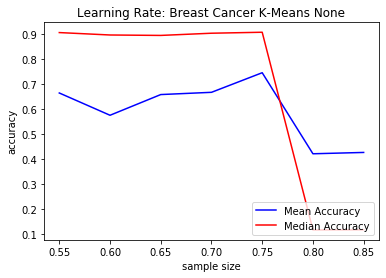

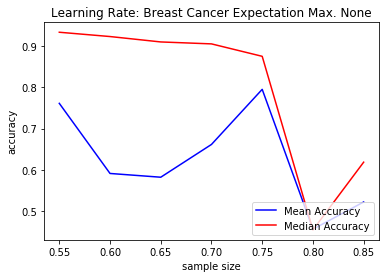

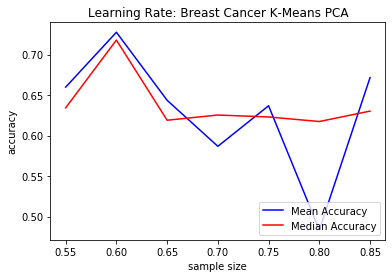

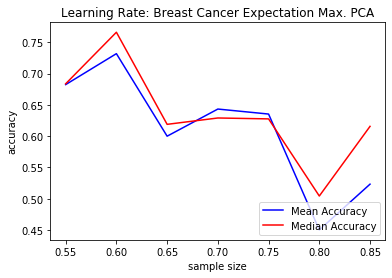

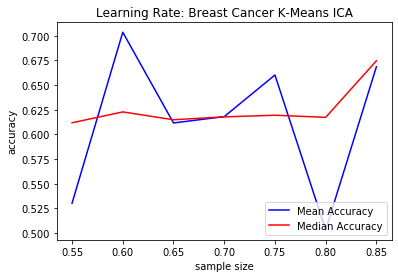

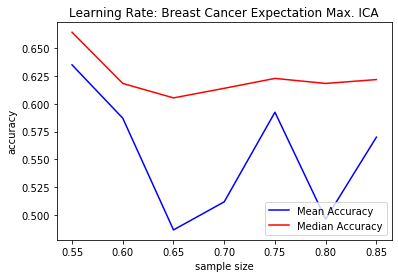

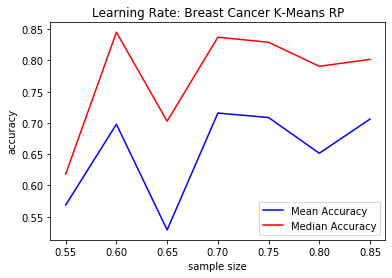

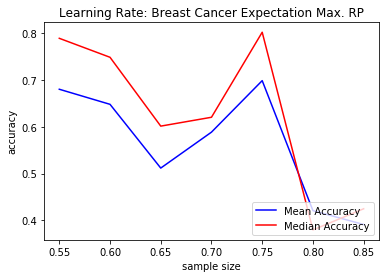

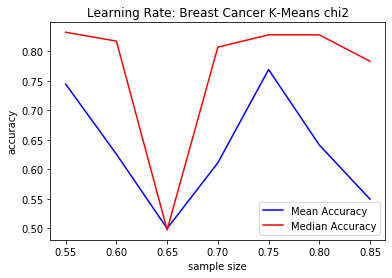

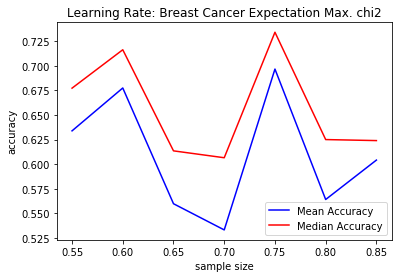

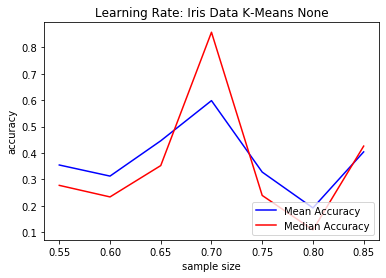

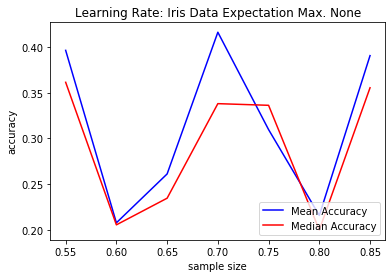

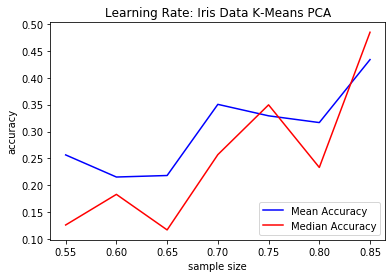

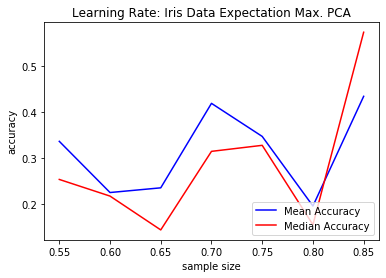

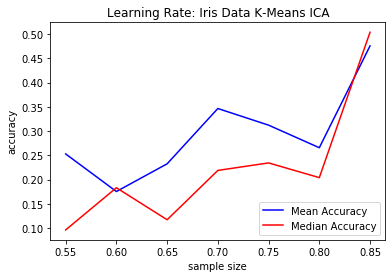

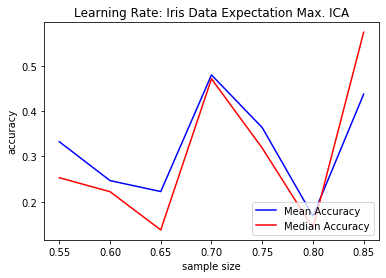

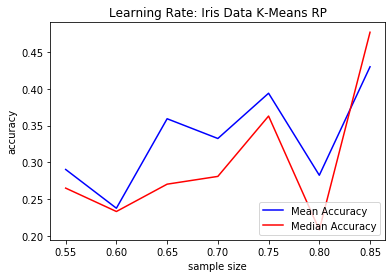

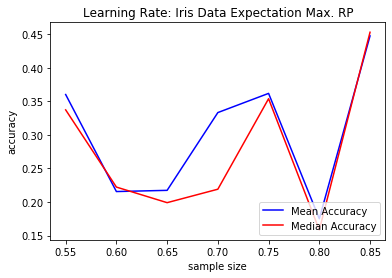

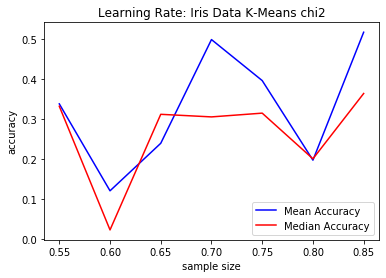

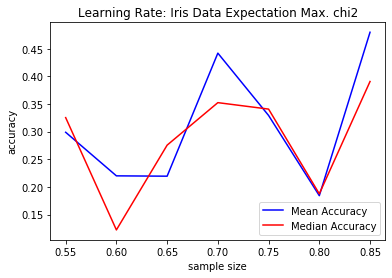

In [172]:
for ds in ['bc','ir']:
  for l in ['None', 'PCA', 'ICA', 'RP', 'chi2']:
        for a in ['km', 'em']:
            name = 'Breast Cancer' if ds == 'bc' else 'Iris Data'
            alg = 'K-Means' if a == 'km' else 'Expectation Max.'
            df = pd.DataFrame(trials[ds][a][l], columns=['seed', 'alg', 'ds', 'fra', 'size', 'accuracy', 'acc_key'])
            dfa = get_aggregates(df)
            show_learning_rate(dfa, 'Learning Rate: {} {} {}'.format(name, alg, l))

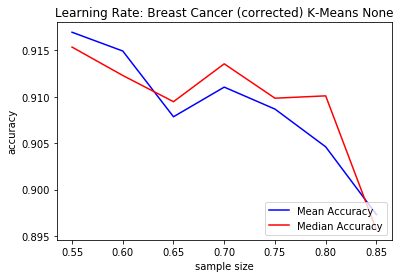

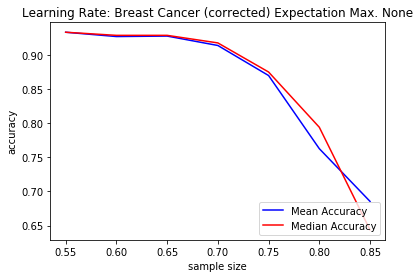

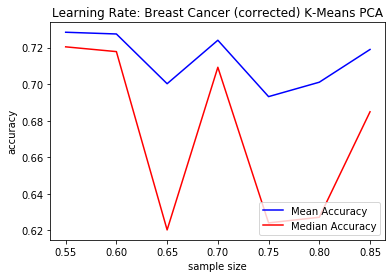

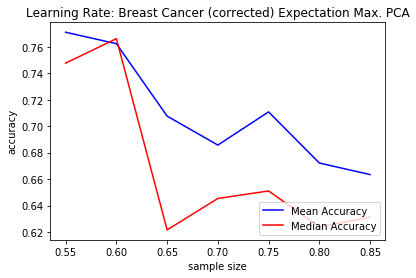

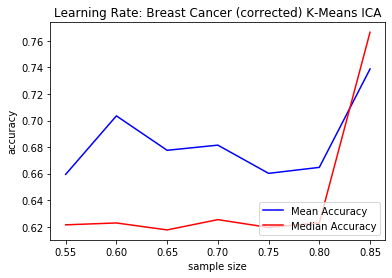

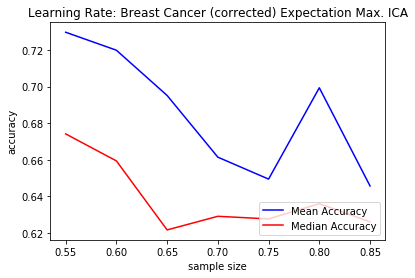

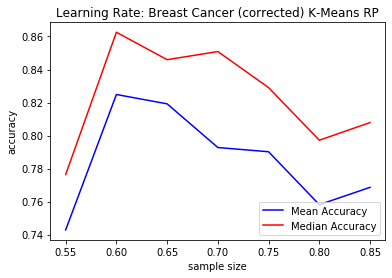

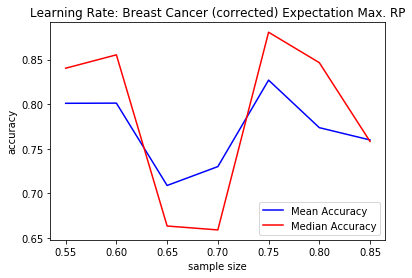

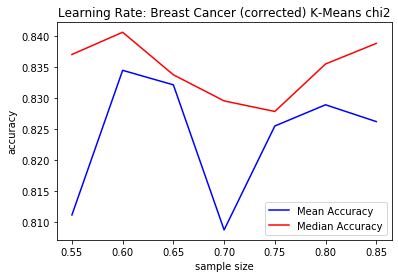

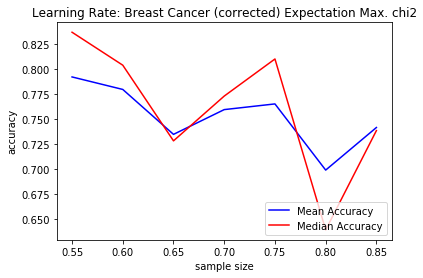

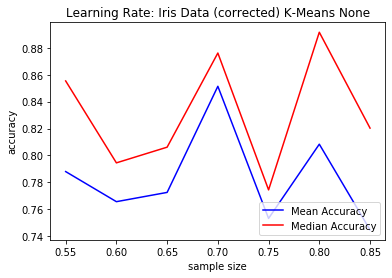

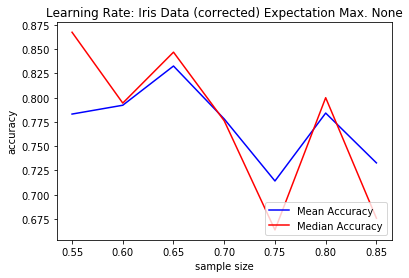

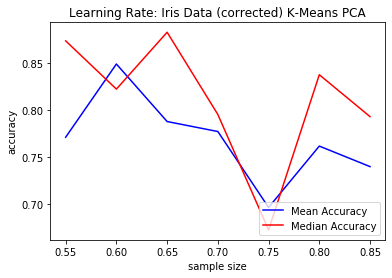

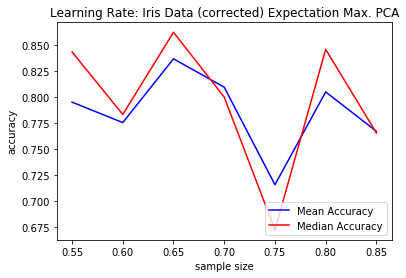

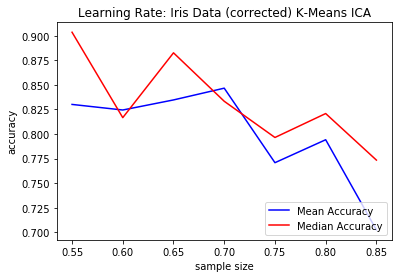

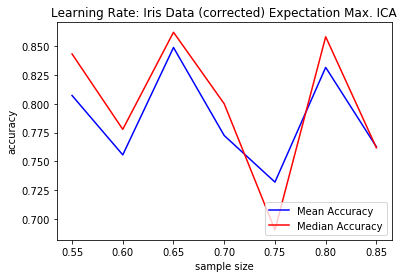

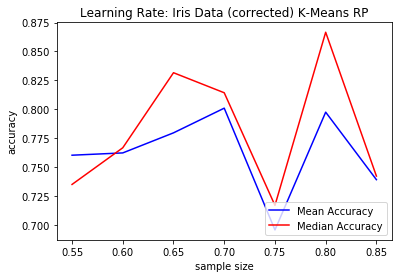

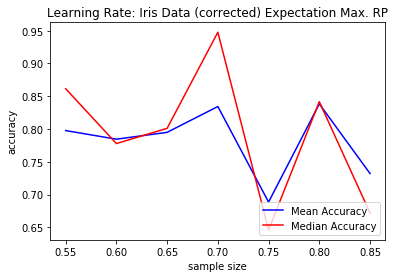

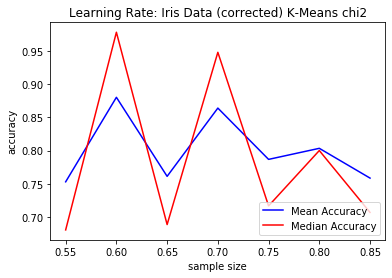

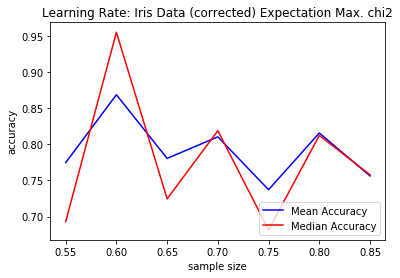

In [173]:
for ds in ['bc','ir']:
  for l in ['None', 'PCA', 'ICA', 'RP', 'chi2']:
        for a in ['km', 'em']:
            name = 'Breast Cancer' if ds == 'bc' else 'Iris Data'
            alg = 'K-Means' if a == 'km' else 'Expectation Max.'
            df = pd.DataFrame(trials[ds][a][l], columns=['seed', 'alg', 'ds', 'fra', 'size', 'accuracy', 'acc_key'])
            df.loc[df['accuracy'] < .5, 'accuracy'] = 1 - df['accuracy'] # this will work for the breast cancer data, but I need to fix it for the iris dataset
            dfa = get_aggregates(df)
            show_learning_rate(dfa, 'Learning Rate: {} (corrected) {} {}'.format(name, alg, l))


In [139]:
len(all_ds['ir']['PCA'])

150

In [189]:
nn_trials = {'bc': {'nn': {'PCA': {},
                           'ICA': {},
                           'RP': {},
                           'chi2': {}}},
             'ir': {'nn': {'PCA': {},
                           'ICA': {},
                           'RP': {},
                           'chi2': {}}}}
for ds in ['bc', 'ir']:
    for l in ['PCA', 'ICA', 'RP', 'chi2']:
#         data = DataFrame(all_ds[ds][l], columns=['feat1', 'feat2','feat3'])
        target = bc_target if ds == 'bc' else ir_data_map.target
        x_train, x_test, y_train, y_test = train_test_split(all_ds[ds][l], target, test_size=.65, random_state = 12345)
        classifier = MLPClassifier(solver='lbfgs', alpha=13e-5, hidden_layer_sizes=(9,9), random_state=12345)
        classifier.fit(x_train, y_train)
        nn_trials[ds]['nn'][l]['is'] = performance(classifier, x_train, y_train)
        nn_trials[ds]['nn'][l]['os'] = performance(classifier, x_test, y_test)
        
        

In [190]:
nn_trials

{'bc': {'nn': {'PCA': {'is': {'accuracy-perc': 0.7889447236180904,
     'error-perc': 0.21105527638190957,
     'mean-error': 0.21105527638190955,
     'error-std': 0.4080575286565186,
     'total-correct': 157,
     'total-incorrect': 42,
     'min-error': 0,
     'max-error': 1,
     'error-counts': {'k0': 157, 'k1': 42}},
    'os': {'accuracy-perc': 0.745945945945946,
     'error-perc': 0.254054054054054,
     'mean-error': 0.25405405405405407,
     'error-std': 0.4353281425232625,
     'total-correct': 276,
     'total-incorrect': 94,
     'min-error': 0,
     'max-error': 1,
     'error-counts': {'k0': 276, 'k1': 94}}},
   'ICA': {'is': {'accuracy-perc': 0.8492462311557789,
     'error-perc': 0.1507537688442211,
     'mean-error': 0.1507537688442211,
     'error-std': 0.35780870590789743,
     'total-correct': 169,
     'total-incorrect': 30,
     'min-error': 0,
     'max-error': 1,
     'error-counts': {'k0': 169, 'k1': 30}},
    'os': {'accuracy-perc': 0.8135135135135135,
     

In [217]:
def try_nn(seed, ds, l, sample_size):
    target = bc_target if ds == 'bc' else ir_data_map.target
    x_train, x_test, y_train, y_test = train_test_split(all_ds[ds][l], target, test_size=sample_size, random_state = seed)
    classifier = MLPClassifier(solver='lbfgs', alpha=13e-5, hidden_layer_sizes=(9,9), random_state=seed)
    classifier.fit(x_train, y_train)
    is_acc = performance(classifier, x_train, y_train)
    os_acc = performance(classifier, x_test, y_test)
    return [sample_size, is_acc, os_acc]

In [218]:
nn_acc = {'bc': {'PCA': [],
                 'ICA': [],
                 'RP': [],
                 'chi2': []},
          'ir': {'PCA': [],
                 'ICA': [],
                 'RP': [],
                 'chi2': []}}

for i in range(10):
    seed = random.randint(1, 999999)
    for ds in ['bc', 'ir']:
        for l in ['PCA', 'ICA', 'RP', 'chi2']:
            for s in [.55, .60, .65, .70,.75,.80,.85,.90,.95]:
                [size, is_acc, os_acc] = try_nn(seed, ds, l, s)
                nn_acc[ds][l].append([seed, size, is_acc['accuracy-perc'], os_acc['accuracy-perc']])

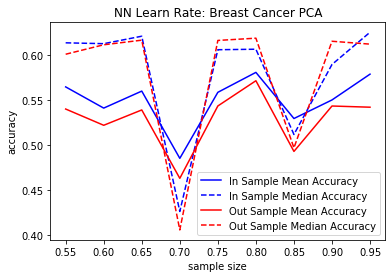

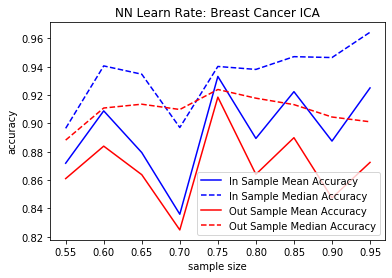

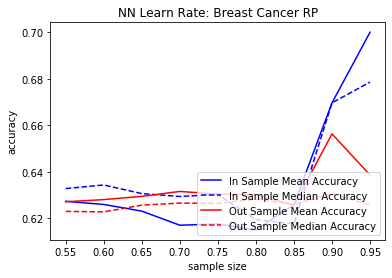

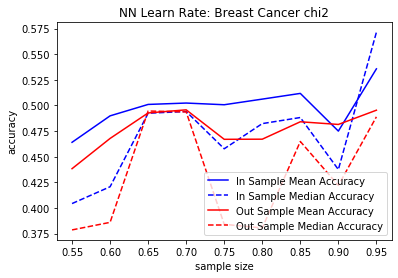

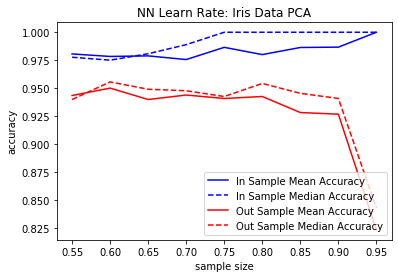

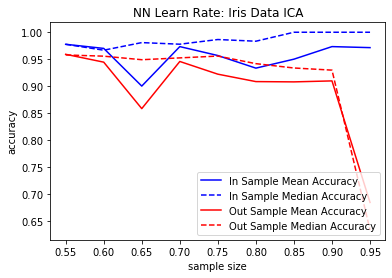

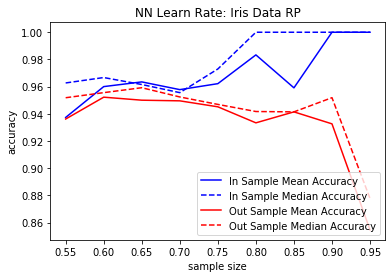

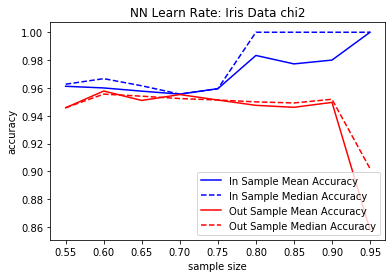

In [229]:
def get_aggregates_nn(attempts):
    att_group = attempts.groupby('size')
    is_fitness_agg = att_group['is'].agg([np.mean, np.std, np.median, np.min, np.max])
    is_fitness_agg.columns = ['In Sample Accuracy Mean', 'In Sample Accuracy Std.', 'In Sample Accuracy Median', 'In Sample Accuracy Min', 'In Sample Accuracy Max']
    os_fitness_agg = att_group['os'].agg([np.mean, np.std, np.median, np.min, np.max])
    os_fitness_agg.columns = ['Out Sample Accuracy Mean', 'Out Sample Accuracy Std.', 'Out Sample Accuracy Median', 'Out Sample Accuracy Min', 'Out Sample Accuracy Max']
    
    comb = pd.concat([is_fitness_agg, os_fitness_agg], axis=1, sort=False)
    return comb

def show_learning_rate_nn(data, title, ylim=None, xlim=None):
    plt.plot(data['In Sample Accuracy Mean'], 'b', data['In Sample Accuracy Median'], 'b--', data['Out Sample Accuracy Mean'], 'r', data['Out Sample Accuracy Median'], 'r--', )
    plt.legend(['In Sample Mean Accuracy', 'In Sample Median Accuracy', 'Out Sample Mean Accuracy', 'Out Sample Median Accuracy'], loc='lower right')
    plt.xlabel('sample size')
    plt.ylabel('accuracy')
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    plt.title(title)
    plt.show()

for ds in ['bc','ir']:
  for l in ['PCA', 'ICA', 'RP', 'chi2']:
        name = 'Breast Cancer' if ds == 'bc' else 'Iris Data'
        df = pd.DataFrame(nn_acc[ds][l], columns=['seed', 'size', 'is', 'os'])
        dfa = get_aggregates_nn(df)
        show_learning_rate_nn(dfa, 'NN Learn Rate: {} {}'.format(name, l))